# Preamble

In [4]:
hparams = {
    "device": "cuda",
    "datatype": "images",
    "dataset_path": "../data/images/",

    "dataset": "CIFAR10",
    "dataset_mean": [0.4914, 0.4822, 0.4465],
    "dataset_std": [0.2023, 0.1994, 0.2010],

    # model
    "arch": "ResNet50",
    "protected": True,
    "in_channels": 4,
    "out_channels": 10,

    # training
    "batch_size_training": 128,
    "batch_size_inference": 300,
    "lr": 0.01,
    "momentum": 0.9,
    "weight_decay": 5e-4,
    "max_epochs": 400,
    "early_stopping": 400,
    "lr_scheduler": "cosine",
    "logging": True,

    "alpha": 0.01,
    "n0": 1_000,
    "n1": 10_000,

    "smoothing_config" : {
        "smoothing_distribution": "patch_ablation",
        "append_indicator": True,
        "k": 150,
        "std": 0.25,
        "d": 1024
    }
}

# Certificate

In [29]:
max_size = 10
plot_data = {}

for s in range(7,8):
    xticks = np.arange(1,max_size) #x-axis entries
    cert_accs = []
    for x in xticks:
        try:
            (votes, correct), accuracy = test(band_size = s, size_to_certify = x)
            #certified = np.array(certificates["multiclass"][x])
            #cert_acc = (certified * correct).mean()
            cert_accs.append(accuracy)
        except:
            cert_accs.append(0)
    plot_data[s] = cert_accs


    
    hparams["smoothing_config"]['s'] = s
    (votes, correct), accuracy = test(band_size = s, size_to_certify = 5)
    #pre_votes = votes.clone()
    #certificates = certify(correct, votes, pre_votes, hparams)
    #certified_by_method = certified.sum()/certified.shape[0] * 100
    #print(certified_by_method)
    

RuntimeError: Given groups=1, weight of size [64, 3, 3, 3], expected input[100, 6, 32, 32] to have 3 channels, but got 6 channels instead

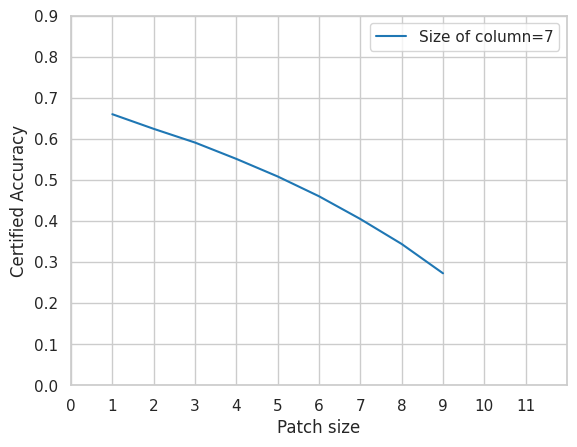

In [86]:
sns.set_style("whitegrid")
sns.set_context("notebook")
fig, ax = plt.subplots(1,1)

for radius in plot_data:
    label = f"Size of column={radius}"
    plt.plot(xticks, [x/100 for x in plot_data[radius]], label=label,zorder=100-radius)

plt.ylim((0, 0.9))
plt.xlim(0,max_size + 2)
plt.xticks(np.arange(0,max_size + 2, 1))
ax.set_xlabel("Patch size")
ax.set_ylabel("Certified Accuracy")
ax.legend()
plt.show()

In [85]:
plot_data[7]

TypeError: unsupported operand type(s) for //: 'list' and 'int'

In [ ]:
certificates = certify(correct, votes, pre_votes, hparams)

In [ ]:
density = 0.01
max_eps = 1.3
plot_data = {}

for r in range(1,5):
    xticks = np.arange(0,max_eps+density*10, density)

    cert_accs = []
    for x in xticks:
        radius = (r,x)
        certified = np.array(certificates["multiclass"][radius[0]]) >= radius[1]
        cert_acc = (certified * correct).mean()
        cert_accs.append(cert_acc)
    plot_data[r] = cert_accs

In [ ]:
from scipy.stats import norm
from scipy.special import comb
import numpy as np
from tqdm.auto import tqdm
from sparse_smoothing.cert import *
import math
import torch



def certify(correct, votes, pre_votes, hparams):
    """Computes lower and upper bound on the label probability
      and then computes certificates depending on the smoothing distribution.

    Args:
        correct (np.array): Array indicating which samples have been correctly
        classified by the smoothed model. Used for the certified accuracy.
        votes (torch.tensor) : Votes per class for each node.
        pre_votes (torch.tensor): Votes per class for each node.
        hparams (dict): Experiment hyperparameters.

    Returns:
        dict: Dictionary containing certificate results
        (binary and multiclass certificates: certified ratios & accuracies).
    """
    p_lower_binary = p_lower_from_votes(
        votes=votes,
        pre_votes=pre_votes,
        alpha=hparams['alpha'],
        n_samples=hparams["n1"]
    )
    p_lower, p_upper = p_lower_upper_from_votes(
        votes=votes,
        pre_votes=pre_votes,
        conf_alpha=hparams['alpha'],
        n_samples=hparams["n1"]
    )
    p_emps = (p_lower_binary, p_lower, p_upper)
    abstain_binary = p_lower_binary <= 0.5
    abstain_multiclass = p_lower <= p_upper
    abstain = (abstain_binary, abstain_multiclass)

    certificates = compute_certificates(correct, abstain, p_emps, hparams, votes)
    return certificates


def compute_certificates(correct, abstain, p_emps, hparams, votes):
    """Selects which certificates have to be computed based on
        the smoothing distribution.

    Args:
        correct (np.array): Array indicating which samples have been correctly
        classified by the smoothed model. Used for the certified accuracy.
        abstain (np.array): Indicates abstained predictions.
        p_emps (tuple): Empirical probabilities.
        hparams (dict): Experiment hyperparameters.

    Raises:
        Exception: Raises exception if certificates for smoothing distribution
        are not implemented.

    Returns:
        dict: Dictionary containing certificate results
        (binary and multiclass certificates: certified ratios & accuracies).
    """

    smoothing_config = hparams['smoothing_config']
    smoothing_distribution = smoothing_config["smoothing_distribution"]
    if smoothing_distribution in ["sparse", "hierarchical_sparse"]:
        # when passing p=1 in hparams we compute sparse smoothing certificates
        cert = hierarchical_sparse_certificate(
            correct, abstain, p_emps, hparams)
    elif smoothing_distribution == "gaussian":
        cert = gaussian_certificate(p_emps, hparams)
    elif smoothing_distribution == "hierarchical_gaussian":
        cert = hierarchical_gaussian_certificate(p_emps, hparams)
    elif smoothing_distribution == "ablation":
        cert = ablation_certificate_scholten(correct, p_emps, hparams)
    elif smoothing_distribution == "ablation_levine":
        cert = ablation_certificate_levine(correct, p_emps, hparams)
    elif smoothing_distribution == "patch_smoothing":
        cert = patch_gaussian_certificate(p_emps, hparams)
    elif smoothing_distribution == "column_smoothing":
        cert = column_gaussian_certificate(p_emps, hparams)
    elif smoothing_distribution == "patch_ablation":
        cert = ablation_certificate_patch(votes, hparams)
    elif smoothing_distribution == "column_ablation":
        cert = ablation_certificate_column(votes, hparams)
    else:
        raise Exception("not implemented")

    cert['abstain_binary'] = abstain[0].tolist()
    cert['abstain_multiclass'] = abstain[1].tolist()
    return cert

def hierarchical_sparse_certificate(correct, abstain, p_emps, hparams):
    """Computes robustness certificates for hierarchical smoothing
    where the lower-level smoothing distribution is initialized
    with sparse smoothing (Bojchevski et al., 2020).

    Computes the sparse smoothing certificates in (Bojchevski et al., 2020)
    as special case for selection probability p=1.

    Aleksandar Bojchevski, Johannes Klicpera, Stephan Günnemann.
    Efficient Robustness Certificates for Discrete Data:
    Sparsity-Aware Randomized Smoothing for Graphs, Images and More. ICML 2020.

    Args:
        correct (np.array): Array indicating which samples have been correctly
        classified by the smoothed model. Used for the certified accuracy.
        abstain (np.array): Indicates abstained predictions.
        p_emps (tuple): Empirical probabilities.
        hparams (dict): Experiment hyperparameters.

    Returns:
        dict: Dictionary containing certificate results
        (binary and multiclass certificates: certified ratios & accuracies).
    """
    smoothing_config = hparams['smoothing_config']
    p = smoothing_config['p']
    pf_plus = smoothing_config['p_plus']
    pf_minus = smoothing_config['p_minus']
    p_lower_binary, p_lower, p_upper = p_emps

    grid_base, regions, base_max_ra, base_max_rd = binary_certificate_grid(
        p=p, pf_plus=pf_plus, pf_minus=pf_minus, p_emps=p_lower_binary,
        reverse=False, progress_bar=True
    )

    grid_lower, *_ = binary_certificate_grid(p=p, pf_plus=pf_plus,
                                             pf_minus=pf_minus, p_emps=p_lower,
                                             reverse=False, regions=regions,
                                             max_ra=base_max_ra,
                                             max_rd=base_max_rd,
                                             progress_bar=True)

    grid_upper, *_ = binary_certificate_grid(p=p, pf_plus=pf_plus,
                                             pf_minus=pf_minus, p_emps=p_upper,
                                             reverse=True, regions=regions,
                                             max_ra=base_max_ra,
                                             max_rd=base_max_rd,
                                             progress_bar=True)

    (abstain_binary, abstain_multiclass) = abstain
    binary_class_cert = (~abstain_binary * (grid_base > 0.5).T)
    multi_class_cert = (~abstain_multiclass * (grid_lower > grid_upper).T)

    # shape: (r, r_a, r_d) after last transpose
    result = {
        "binary": {
            "ratios": binary_class_cert.mean(-1).T,
            "cert_acc": (correct * binary_class_cert).mean(-1).T
        },
        "multiclass": {
            "ratios": multi_class_cert.mean(-1).T,
            "cert_acc": (correct * multi_class_cert).mean(-1).T
        }
    }

    return result


def binary_certificate_grid(p, pf_plus, pf_minus, p_emps,
                            reverse=False, regions=None,
                            max_ra=None, max_rd=None,
                            max_radius=100,
                            progress_bar=True):
    """Code to support efficient certificates for hierarchical
    smoothing with sparse smoothing, adapted from the official reference
    of the paper (Bojchevski et al., 2020):

    - https://github.com/abojchevski/sparse_smoothing/blob/master/sparse_smoothing/cert.py#L535

    Aleksandar Bojchevski, Johannes Klicpera, Stephan Günnemann.
    Efficient Robustness Certificates for Discrete Data:
    Sparsity-Aware Randomized Smoothing for Graphs, Images and More. ICML 2020.
    """
    if progress_bar:
        def bar(loop):
            return tqdm(loop)
    else:
        def bar(loop):
            return loop

    if p == 1:
        max_r = 0
    else:
        # we set the maximum radius to 100 for performance reasons
        # adapt if necessary
        assert p < 0.5**(1/max_radius) and p > 0.5
        max_r = max([x for x in range(1, max_radius) if p > 0.5**(1/x)])

    if regions is None:
        if max_ra is None or max_rd is None:
            max_p_emp = p_emps.max()
            print("determine max radius r_a")
            max_ra = max_radius_for_p_emp(
                pf_plus=pf_plus, pf_minus=pf_minus,
                p_emp=max_p_emp, which='ra', upper=100)
            print("determine max radius r_d")
            max_rd = max_radius_for_p_emp(
                pf_plus=pf_plus, pf_minus=pf_minus,
                p_emp=max_p_emp, which='rd', upper=100)
            min_p_emp = min(min_p_emp_for_radius_1(pf_plus, pf_minus, 'ra'),
                            min_p_emp_for_radius_1(pf_plus, pf_minus, 'rd'))
            print(
                f'max_ra={max_ra}, max_rd={max_rd}, min_p_emp={min_p_emp:.4f}')

        regions = {}
        for r in bar(range(1, max_r + 2)):
            for ra in bar(range(max_ra + 2)):
                for rd in range(max_rd + 2):
                    regions[(r, ra, rd)] = regions_binary(
                        ra=ra, rd=rd, pf_plus=pf_plus, pf_minus=pf_minus)
                    regions[(r, ra, rd)][:, :2] *= p**r

    n_nodes = len(p_emps)
    arng = np.arange(n_nodes)
    radii = np.zeros((n_nodes, max_r+2, max_ra + 2, max_rd + 2))

    for (r, ra, rd), regions_ra_rd in bar(regions.items()):
        if ra + rd == 0 or r == 0:
            radii[arng, r, ra, rd] = 1 if not reverse else 0
        else:
            delta = (1-p**r)
            if reverse:
                radii[arng, r, ra, rd] = compute_rho_for_many(
                    regions=regions_ra_rd, p_emps=p_emps,
                    is_sorted=True, reverse=reverse) + delta
            else:
                radii[arng, r, ra, rd] = compute_rho_for_many(
                    regions=regions_ra_rd, p_emps=p_emps-delta,
                    is_sorted=True, reverse=reverse)

    return radii, regions, max_ra, max_rd


def max_radius_for_p_emp(pf_plus, pf_minus, p_emp,
                         which, upper=100, verbose=False):
    """Code to support efficient certificates for hierarchical
    smoothing with sparse smoothing, adapted from the official reference
    of the paper (Bojchevski et al., 2020):

    - https://github.com/abojchevski/sparse_smoothing/blob/master/sparse_smoothing/cert.py#L409

    Aleksandar Bojchevski, Johannes Klicpera, Stephan Günnemann.
    Efficient Robustness Certificates for Discrete Data:
    Sparsity-Aware Randomized Smoothing for Graphs, Images and More. ICML 2020.
    """
    lower = 1
    r = 1

    while lower < upper:
        r = lower + (upper - lower) // 2
        if which == 'ra':
            ra = r
            rd = 0
        elif which == 'rd':
            ra = 0
            rd = r
        else:
            raise ValueError('which can only be "ra" or "rd"')

        cur_rho = compute_rho(regions_binary(
            ra=ra, rd=rd, pf_plus=pf_plus, pf_minus=pf_minus), p_emp)
        if verbose:
            print(r, float(cur_rho))

        if cur_rho > 0.5:
            if lower == r:
                break
            lower = r
        else:
            upper = r

    return r


def hierarchical_gaussian_certificate(p_emps, hparams, steps=0.001, max=100):
    """Computes the largest certifiable radius for hierarchical smoothing
    where the lower-level smoothing distribution is initialized
    with Gaussian smoothing (Cohen et al., 2019).

    Args:
        p_emps (tuple): Empirical probabilities.
        hparams (dict): Experiment hyperparameters.
        steps (float, optional): We compute certificaes for epsilon
        until classifier is not certifiable robust anymore. Allows to define
        the stepsize of continuous epsilon. Defaults to 0.001.
        max (int, optional): Largest radius r to compute certificates for.
        Defaults to 100.

    Returns:
        dict: Radii for binary and multiclass certificates.
    """
    p_lower_binary, p_lower, p_upper = p_emps
    smoothing_config = hparams['smoothing_config']
    sigma = smoothing_config["std"]
    k = smoothing_config["k"]
    d = smoothing_config["d"]
    p = 1-k/d

    radii_binary = {}

    r = 0
    while True:
        r += 1
        delta = 1-p**r
        radii_binary[r] = sigma * (norm.ppf((p_lower_binary-delta)/(p**r))
                                   - norm.ppf(1/(2*(1-delta))))
        if not (radii_binary[r] > 0).any() or r >= max:
            radii_binary[r] = radii_binary[r].tolist()
            break
        radii_binary[r] = radii_binary[r].tolist()

    multiclass = {}

    r = 0
    while True:
        r += 1
        delta = 1-p**r

        multiclass[r] = []
        eps = 0
        while True:
            left = norm.cdf(norm.ppf((p_lower-delta)/(p**r)) - eps/sigma)*p**r
            right = norm.cdf(norm.ppf(p_upper/(p**r))+eps/sigma)*p**r + delta
            robust = left > right
            multiclass[r].append(robust.tolist())
            eps += steps
            if not robust.any():
                break

        multiclass[r] = np.array(multiclass[r]).argmin(0)*steps
        if not (multiclass[r] > 0).any() or r >= max:
            multiclass[r] = multiclass[r].tolist()
            break
        multiclass[r] = multiclass[r].tolist()

    result = {
        "binary": radii_binary,
        "multiclass": multiclass
    }
    return result


def gaussian_certificate(p_emps, hparams):
    """Computes the largest certifiable radius for smoothing classifiers with
    Gaussian smoothing (Cohen et al., 2019). Certified ratios and accuracies
    have to be computed at plotting time based on the ratios.

    Jeremy Cohen, Elan Rosenfeld, J. Zico Kolter.
    Certified Adversarial Robustness via Randomized Smoothing. ICML 2019.

    Args:
        p_emps (tuple): Empirical probabilities.
        hparams (dict): Experiment hyperparameters.

    Returns:
        dict: Radii for binary and multiclass certificates.
    """
    p_lower_binary, p_lower, p_upper = p_emps
    smoothing_config = hparams['smoothing_config']
    sigma = smoothing_config["std"]

    binary_cert = sigma * norm.ppf(p_lower_binary)
    multiclass_cert = sigma/2 * (norm.ppf(p_lower) - norm.ppf(p_upper))
    result = {
        "binary": binary_cert.tolist(),
        "multiclass": multiclass_cert.tolist()
    }
    return result


def ablation_certificate_scholten(correct, p_emps, hparams):
    """Computes ablation certificates for the smoothing distribution
    proposed in (Scholten et al., 2022).

    Yan Scholten, Jan Schuchardt, Simon Geisler, Aleksandar Bojchevski,
    and Stephan Günnemann. Randomized Message-Interception Smoothing:
    Gray-box Certificates for Graph Neural Networks. NeurIPS 2022.

    Args:
        correct (np.array): Array indicating which samples have been correctly
        classified by the smoothed model. Used for the certified accuracy.
        p_emps (tuple): Empirical probabilities.
        hparams (dict): Experiment hyperparameters.

    Returns:
        dict: Dictionary containing certificate results
        (binary and multiclass certificates: certified ratios & accuracies).
    """
    p_lower_binary, p_lower, p_upper = p_emps
    smoothing_config = hparams['smoothing_config']
    p = smoothing_config["p"]

    robust_binary = {}
    robust_multi = {}

    r = 0
    while True:
        r += 1
        delta = 1-p**r
        robust_binary[r] = (p_lower_binary-delta > 0.5)
        if not robust_binary[r].any():
            break

    r = 0
    while True:
        r += 1
        delta = 1-p**r
        robust_multi[r] = (p_lower-delta > p_upper+delta)
        if not robust_multi[r].any():
            break

    result = {
        "binary": {
            "cert_ratios": [robust_binary[r].mean()
                            for r in robust_binary],
            "cert_accs": [(robust_binary[r]*correct).mean()
                          for r in robust_binary]
        },
        "multiclass": {
            "cert_ratios": [robust_multi[r].mean()
                            for r in robust_multi],
            "cert_accs": [(robust_multi[r]*correct).mean()
                          for r in robust_multi]
        }
    }
    return result


def ablation_certificate_levine(correct, p_emps, hparams):
    """Computes ablation certificates for the smoothing distribution
    proposed in (Levine et al., 2020).

    Alexander Levine, Soheil Feizi. Robustness Certificates for Sparse
    Adversarial Attacks by Randomized Ablation. AAAI 2020.

    Args:
        correct (np.array): Array indicating which samples have been correctly
        classified by the smoothed model. Used for the certified accuracy.
        p_emps (tuple): Empirical probabilities.
        hparams (dict): Experiment hyperparameters.

    Returns:
        dict: Dictionary containing certificate results
        (binary and multiclass certificates: certified ratios & accuracies).
    """
    p_lower_binary, p_lower, p_upper = p_emps
    smoothing_config = hparams['smoothing_config']
    k = smoothing_config["k"]
    d = smoothing_config["d"]

    robust_binary = {}
    robust_multi = {}

    r = 0
    while True:
        r += 1
        numerator = math.factorial(d-r) * math.factorial(d-k)
        denominator = math.factorial(d) * math.factorial(d-k-r)
        delta = 1 - numerator / denominator

        robust_binary[r] = (p_lower_binary-delta > 0.5)
        if not robust_binary[r].any():
            break

    r = 0
    while True:
        r += 1
        numerator = math.factorial(d-r) * math.factorial(d-k)
        denominator = math.factorial(d) * math.factorial(d-k-r)
        delta = 1 - numerator / denominator

        robust_multi[r] = (p_lower-delta > p_upper+delta)
        if not robust_multi[r].any():
            break

    result = {
        "binary": {
            "cert_ratios": [robust_binary[r].mean()
                            for r in robust_binary],
            "cert_accs": [(robust_binary[r]*correct).mean()
                          for r in robust_binary]
        },
        "multiclass": {
            "cert_ratios": [robust_multi[r].mean()
                            for r in robust_multi],
            "cert_accs": [(robust_multi[r]*correct).mean()
                          for r in robust_multi]
        }
    }
    return result


def patch_gaussian_certificate(p_emps, hparams, steps=0.001, max=100):

    p_lower_binary, p_lower, p_upper = p_emps

    smoothing_config = hparams['smoothing_config']
    sigma = smoothing_config["std"]
    k = smoothing_config["k"]
    s = smoothing_config["s"]
    size = smoothing_config["d"]

    radii_binary = {}

    r = 0
    while True:
        r += 1
        delta = (s + r - 1)**2/size
        radii_binary[r] = sigma * (norm.ppf((p_lower_binary-delta)/(1-delta))
                                   - norm.ppf(1/(2*(1-delta))))
        if not (radii_binary[r] > 0).any() or r >= max:
            radii_binary[r] = radii_binary[r].tolist()
            break
        radii_binary[r] = radii_binary[r].tolist()

    multiclass = {}

    r = 0
    while True:
        r += 1
        delta = (s + r - 1)**2/size

        multiclass[r] = []
        eps = 0
        while True:
            left = norm.cdf(norm.ppf((p_lower-delta)/(1 - delta)) - eps/sigma)*(1 - delta)
            right = norm.cdf(norm.ppf(p_upper/(1 - delta))+eps/sigma)*(1 - delta) + delta
            robust = left > right
            multiclass[r].append(robust.tolist())
            eps += steps
            if not robust.any():
                break

        multiclass[r] = np.array(multiclass[r]).argmin(0)*steps
        if not (multiclass[r] > 0).any() or r >= max:
            multiclass[r] = multiclass[r].tolist()
            break
        multiclass[r] = multiclass[r].tolist()

    result = {
        "binary": radii_binary,
        "multiclass": multiclass
    }
    return result

def column_gaussian_certificate(p_emps, hparams, steps=0.001, max=100):

    p_lower_binary, p_lower, p_upper = p_emps
    smoothing_config = hparams['smoothing_config']
    sigma = smoothing_config["std"]
    k = smoothing_config["k"]
    s = smoothing_config["s"]
    width = smoothing_config["w"]
    radii_binary = {}

    r = 0
    while True:
        r += 1
        delta = (s + r - 1)/width
        radii_binary[r] = sigma * (norm.ppf((p_lower_binary-delta)/(1-delta))
                                   - norm.ppf(1/(2*(1-delta))))
        if not (radii_binary[r] > 0).any() or r >= max:
            radii_binary[r] = radii_binary[r].tolist()
            break
        radii_binary[r] = radii_binary[r].tolist()

    multiclass = {}

    r = 0
    while True:
        r += 1
        delta = (s + r - 1)/width

        multiclass[r] = []
        eps = 0
        while True:
            left = norm.cdf(norm.ppf((p_lower-delta)/(1 - delta)) - eps/sigma)*(1 - delta)
            right = norm.cdf(norm.ppf(p_upper/(1 - delta))+eps/sigma)*(1 - delta) + delta
            robust = left > right
            multiclass[r].append(robust.tolist())
            eps += steps
            if not robust.any():
                break

        multiclass[r] = np.array(multiclass[r]).argmin(0)*steps
        if not (multiclass[r] > 0).any() or r >= max:
            multiclass[r] = multiclass[r].tolist()
            break
        multiclass[r] = multiclass[r].tolist()

    result = {
        "binary": radii_binary,
        "multiclass": multiclass
    }
    return result



def ablation_certificate_patch(votes, hparams, max = 100):
    #votes is a tensor with number of votes for each class in shape num_samples x classes
    radii_multiclass = {}
    top_values, top_indices = torch.topk(votes, k=2, dim=1)
    #print(top_values[:,1].unique(return_counts=True))
    smoothing_config = hparams['smoothing_config']
    
    
    r = 0
    while True:
      r += 1
      radii_multiclass[r] = top_values[:,0] > top_values[:, 1] + torch.tensor(top_indices[:,0] > top_indices[:,1] , dtype=torch.int).clone().detach() + 2 * (smoothing_config['s']+r-1)**2
      
      if not (radii_multiclass[r] > 0).any() or r >= max:
            radii_multiclass[r] = radii_multiclass[r].tolist()
            break
      radii_multiclass[r] = radii_multiclass[r].tolist()

    result = {
            "multiclass": radii_multiclass,
            "binary": radii_multiclass,
        }
    #print(radii_multiclass[10])    
    return result
    

def ablation_certificate_column(votes, hparams, max = 100):
    #votes is a tensor with number of votes for each class in shape num_samples x classes
    radii_multiclass = {}
    top_values, top_indices = torch.topk(votes, k=2, dim=1)
    #print(top_values[:,1].unique(return_counts=True))
    smoothing_config = hparams['smoothing_config']
    
    
    r = 0
    while True:
      r += 1
      radii_multiclass[r] = top_values[:,0] > top_values[:, 1] + torch.tensor(top_indices[:,0] > top_indices[:,1] , dtype=torch.int).clone().detach() + 2 * (smoothing_config['s']+r-1)
      
      if not (radii_multiclass[r] > 0).any() or r >= max:
            radii_multiclass[r] = radii_multiclass[r].tolist()
            break
      radii_multiclass[r] = radii_multiclass[r].tolist()

    result = {
            "multiclass": radii_multiclass,
            "binary": radii_multiclass,
        }
    #print(radii_multiclass[10])    
    return result
    





In [ ]:
from src.utils import prob_func
import math

def ploting_lines()

    sticker_size = 5
    block_size = 15
    delta_norm = 0.5
    delta = torch.zeros((1,32,32))
    delta[:,0:sticker_size,0:sticker_size] = 1
    norm_norm =  np.linalg.norm(delta)
    delta = delta_norm/norm_norm * delta
    delta_value = delta[:,0,0].item()
    sigma = 0.5
    delta_block = min(1,(block_size + sticker_size -1) **2 / (delta.shape[1]*delta.shape[2]))
    p_x_r1 = prob_func(1,delta, block_size, sigma, sign=1)
    p_x_r2 = 1 - delta_block
    p_x_r3 = prob_func(1,delta, block_size, sigma, sign=-1)
    print(p_x_r1, p_x_r2,p_x_r3)
    #values = generate_line(p_x_r1,p_x_r2,p_x_r3, delta, block_size, sigma)
    worst_case,old_worst_case = generate_line_worstcases(delta, Delta_block ,block_size, sigma)
    values_gamma = generate_line_gamma(delta,delta_value, block_size,sticker_size=sticker_size, gamma = sigma)
    values_cohen = generate_line_cohen(delta, sigma)
    import matplotlib.pyplot as plt#0.05501345274703142 0.9208984375 0.02408, 5-5
    x_values =np.arange(0,1.0001,0.0001)

    plt.plot(x_values, x_values, label='$p_{x,y}$')
    #plt.plot(x_values, values, label='$p_{\tilde{X},y}$ uniform delta distr.')
    plt.plot(x_values, old_worst_case, label='$p_{x,y} - \Delta$') 
    plt.plot(x_values, values_gamma, label='ours, uniform noise', color = 'red')
    plt.plot(x_values, values_cohen, label=r'$p_{\tilde{X},y}$ Randomized Smoothing')
    #plt.plot(x_values, worst_case, label=r'$p_{\tilde{X},y}$ ours, worst case')
    plt.axhline(y= 0.5, color='r', linestyle='--', label='0.5')
    plt.xlim(0,1.1)
    plt.legend(title = f'$\sigma={sigma},$ $\|\delta\|_2={delta_norm}$')
    plt.savefig('lower_bounds_patch.png') 
    plt.show()


0.2277343931505301 0.6474609375 0.12480466934946924


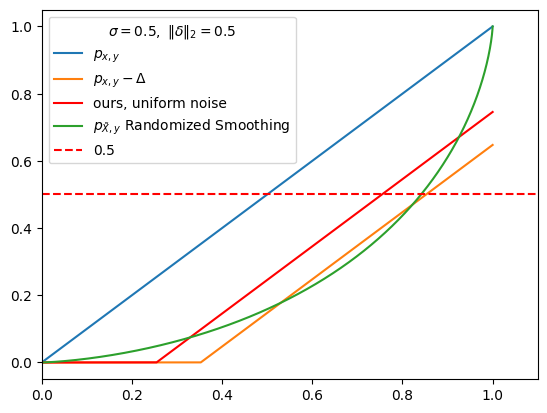

In [ ]:
import matplotlib.pyplot as plt #0.14244729235079368 0.80859375 0.04895895764920628 10 - 5
x_values = np.linspace(0, 1, len(id))
plt.plot(x_values, id, label='id')
plt.plot(x_values, values, label=r'$p_{\tilde{X},y}$')
plt.plot(x_values, values1, label=r'$p_{\tilde{X},y}$ worst case')
plt.axhline(y= p_x_r2 + p_x_r3, color='r', linestyle='--', label=' p_x_r2 + p_x_r3')
plt.xlim(0,1.1)
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
#We plot P_X(R_1) (first plot) vs P_X(R_3) (second plot), which gives 
#for different sigmas and perturbation strength the ratio between R_1 and R_3  
# Plot vals
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
for sigma in sigmas:
    vals = []
    for delta_value in delta_values:
        delta = torch.zeros(pictures[2][0:3,:,:].shape)
        delta[:, 0:sticker_size, 0:sticker_size] = math.sqrt(delta_value**2 / (3 * 5 * 5))
        delta_norm = np.linalg.norm(delta)
        Delta_block = (block_size + sticker_size - 1) ** 2 / (delta.shape[1] * delta.shape[2])
        vals.append(prob_func(1, delta, block_size, sigma, sign=1))
    
    plt.plot(delta_values, vals, label=f'sigma={sigma}')

plt.xlabel('Delta values')
plt.ylabel(r'$P_X(R_1)$')
plt.axhline(y=1 - p_x_r2, color='r', linestyle='--', label='1-p_x_r2')
plt.xlim(0, 4)  # Adjust the x-axis limit as needed
plt.legend()
plt.title(r'$P_X(R_1)$')
plt.show()

# Plot vals2
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
for sigma in sigmas:
    vals2 = []
    for delta_value in delta_values:
        delta = torch.zeros(pictures[2][0:3,:,:].shape)
        delta[:, 0:sticker_size, 0:sticker_size] = math.sqrt(delta_value**2 / (3 * 5 * 5))
        #delta_norm = np.linalg.norm(delta)
        Delta_block = (block_size + sticker_size - 1) ** 2 / (delta.shape[1] * delta.shape[2])
        vals2.append(prob_func(1, delta, block_size, sigma, sign=-1))
    
    plt.plot(delta_values, vals2, label=f'sigma={sigma}')

plt.xlabel('Delta values')
plt.ylabel(r'$P_X(R_3)$')
plt.axhline(y=1 - p_x_r2, color='r', linestyle='--', label='1-p_x_r2')
plt.xlim(0, 4)  # Adjust the x-axis limit as needed
plt.legend()
plt.title(r'$P_X(R_3)$')
plt.show()
